# Project Abysima: Language Generation Experiments

The following notebook will experiment with generating a language using neural networks and generative deep learning.
This is, by no means, a production-ready system, nor is it a complete network; rather, the purpose of this experiment
is to see what is possible with creating a language.

For more information on the process and supporting research, please refer to the Linguistics Paper document found in the
`01 - Areas of Responsibility` directory.

The following source code and datasets are licensed under the Mozilla Public License v2.0. Please refer to the LICENSE
file that came with this repository for more information on what your rights are with usage and modification of this
software. If a LICENSE file is not provided, you can obtain a copy at https://www.mozilla.org/en-US/MPL/2.0/.

## Part 1: Collecting the Dataset

Before we can create networks that will be able to train off of words, sniglets, and non-words, we first need to create
a dataset that the networking models will be able to understand.

To do this, we will create two pools of data: a list full of valid words, and a list of random strings, both of equal
count. The list of valid words derives from the words found in the `/usr/share/dict/words` file found on UNIX and Linux
systems, which contains words of various languages. A list of basic Japanese words written in Romaji are also included
in the list.

Words in the valid pool are then trimmed based on the average length of the words in that dataset, removing any words
that are bigger than the specified length. This is crucial because this will help prevent miscalculations due to a lot
of whitespace. Additionally, words that are acronyms, contractions, and/or less than three characters long are removed
from the list. The invalid word dataset is generated from an algorithm that randomly selects letters from three to the
average length.

Neural networks need each entry in the dataset to be of the same length, since they are fundamentally rows in a large
matrix. To accomplish this, we will append asterisks (`'*'`) at the end of words when needed; this is known as _padding_
_a sequence_.

We also need to be able to indicate which words are valid and which ones were randomly generated. To do this, we will
add an extra column to the dataset that will indicate its validity by writing either "valid" or "invalid".

The dataset is then shuffled between twenty-five to fifty times to make sure that we aren't only training on valid words
or vice-versa. Once this shuffling is complete, we will split the dataset into two pools, where eighty percent (80%) of
the data will go into a training pool, and twenty percent (20%) will go into a testing pool. The training pool will be
used to train the network, and the testing pool will be used to test that the trained network is making as close to an
accurate prediction as possible.

We then take these two pools and write them to CSV files which all of our models will be able to read. The script that
implements this process is available in `create_dataset.py` in the project's root.

In [25]:
# Import the Pandas library, which will read the CSV files that we wrote.
import pandas as pd

# Import the training and testing pools.
DF_TRAINING_POOL = pd.read_csv("../datasets/dtrain.csv")
DF_TESTING_POOL = pd.read_csv("../datasets/dtest.csv")

# Make a preview of the data frame from the training pool. Note that our features are the eight characters, and the
# target is the 'Valid' column.
DF_TRAINING_POOL.head()

,char01,char02,char03,char04,char05,char06,char07,char08,Valid
0,v,f,t,*,*,*,*,*,invalid
1,f,y,u,t,*,*,*,*,invalid
2,g,l,e,a,n,i,n,g,valid
3,a,l,l,o,v,e,r,*,valid
4,c,r,u,s,t,y,*,*,valid


In [26]:
# Neural networks will need to encode the data in order to be able to train. We will write an encoder and apply it to
# the dataset here.
from string import ascii_lowercase
import numpy as np


def encode_features(feature) -> float:
    """Returns an encoded number that represents the data item."""
    if feature == '*' or feature == 'invalid':
        return 0.0
    elif feature == 'valid':
        return 1.0
    else:
        return (ascii_lowercase.index(feature) + 1) / 26.0


# Convert the data frames into NumPy arrays, which will be used in the neural networks.
DATA_TRAIN = DF_TRAINING_POOL.to_numpy()
DATA_TEST = DF_TESTING_POOL.to_numpy()

# Make the mapping function that will convert the strings in the datasets into numbers with the function we defined
# earlier and map them on our datasets.
map_func = np.vectorize(encode_features)
DATA_TRAIN = map_func(DATA_TRAIN)
DATA_TEST = map_func(DATA_TEST)

DATASET_COUNT = DATA_TRAIN.shape[0] + DATA_TEST.shape[0]  # type: ignore

# Print out the sizes of the training and testing datasets.
print(f"Train shape: {DATA_TRAIN.shape}")  # type: ignore
print(f"Test shape: {DATA_TEST.shape}")  # type: ignore
print(f"Total rows: {DATASET_COUNT}")


Train shape: (79572, 9)
Test shape: (19894, 9)
Total rows: 99466


In [27]:
# Split the training and testing datasets into X and Y components. X will contain all of the features, and Y will
# contain the target value.
X_train, y_train = DATA_TRAIN[:, :-1], DATA_TRAIN[:, -1]  # type: ignore
X_test, y_test = DATA_TEST[:, :-1], DATA_TEST[:, -1]  # type: ignore

print(X_train[:5])
print(y_train[:5])

[[0.84615385 0.23076923 0.76923077 0.         0.         0.
  0.         0.        ]
 [0.23076923 0.96153846 0.80769231 0.76923077 0.         0.
  0.         0.        ]
 [0.26923077 0.46153846 0.19230769 0.03846154 0.53846154 0.34615385
  0.53846154 0.26923077]
 [0.03846154 0.46153846 0.46153846 0.57692308 0.84615385 0.19230769
  0.69230769 0.        ]
 [0.11538462 0.69230769 0.80769231 0.73076923 0.76923077 0.96153846
  0.         0.        ]]
[0. 0. 1. 1. 1.]


## Part 2: Creating our Networks

Now that we have our dataset ready, we will begin creating neural networks that will train on the data we specify.
These neural networks operate similar to our own brains and will try to "learn" what makes a word valid by using
mathematical equations running in the background.

To accomplish this, we will utilize two frameworks that exist: Tensorflow and CoreML. Tensorflow is a library created
by Google to make neural networks from scratch without writing all of the code to process the math. Likewise, CoreML
is a library made by Apple that lets developers create neural networks for use in apps on their platforms (macOS, iOS,
tvOS, and watchOS).

For this experiment, we will design three networks:

- First, a fully-connected neural network (FCNN). This type of network indicates that all of the nodes in the network
  link up to each other in some way. This is the most "basic" neural network in the list.
- Next, a recurrent neural network (RNN) using the Long Short-Term Memory strategy (LSTM). Recurrent neural networks
  operate very similarly to FCNNs in that nodes are connected. However, it recognizes that the data it receives is
  sequential, meaning that they appear in a sequence. The network will perform mathematical operations and learn with
  this in mind.
- Finally, a CoreML model created with Create ML. This dataset is pre-trained and automatically selected an algorithm
  that it thinks works best for the dataset. Exact implementation is unknown since Apple hides this from the developer.

In [28]:
# We will specify parameters here that will be used to train the networks we are creating. These parameters can be
# adjusted by us at any time to optimize the algorithms. These parameters are known as 'hyperparameters'.

# Specify the number of "iterations" the neural networks will run under. In this case, an iteration indicates a session
# of training by reading the data and running operations on it.
KERAS_EPOCHS = 500

# Specify the number of batches the neural networks will use. To speed up training, our networks will run updates after
# a certain number of batches, making updates as necessary.
KERAS_BATCHES = 512

In [29]:
# Import the Tensorflow and Keras libraries needed to make two of the networks.
from tensorflow import keras
from tensorflow.keras.layers import Dense

# Create the FCNN. This will have a first layer that maps to the number of characters in our set: in this case, 8. We
# also include some hidden layers of various lengths before including a final layer that will filter down to a single
# input.
FCNN = keras.Sequential()
FCNN.add(Dense(8, input_dim=8, activation="relu"))
FCNN.add(Dense(32, activation='relu'))
FCNN.add(Dense(1, activation="sigmoid"))

# Compile the model and use 'binary cross-entropy' to foce the network to either say "yes" or "no". We will also use the
# adam optimizer and list accuracy in our metrics for further analysis.
FCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print out a summary of the FCNN.
FCNN.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


In [30]:
# We will now begin training the FCNN with the training data we encoded earlier, using the hyperparameters we defined.
# To prevent overcorrection or memorization of the data, we will dedicate 20% of the data to validation. We will store
# the results of the training session for later analysis.
FCNN_results = FCNN.fit(X_train,
                        y_train,
                        epochs=KERAS_EPOCHS,
                        batch_size=KERAS_BATCHES,
                        verbose=1,
                        validation_split=0.2)

Epoch 1/500
125/125 [==============================] - 1s 7ms/step - loss: 0.6528 - accuracy: 0.6106 - val_loss: 0.6022 - val_accuracy: 0.6842
Epoch 2/500
125/125 [==============================] - 1s 5ms/step - loss: 0.5664 - accuracy: 0.7092 - val_loss: 0.5500 - val_accuracy: 0.7108
Epoch 3/500
125/125 [==============================] - 1s 5ms/step - loss: 0.5301 - accuracy: 0.7181 - val_loss: 0.5231 - val_accuracy: 0.7240
Epoch 4/500
125/125 [==============================] - 1s 5ms/step - loss: 0.5081 - accuracy: 0.7353 - val_loss: 0.5041 - val_accuracy: 0.7407
Epoch 5/500
125/125 [==============================] - 1s 5ms/step - loss: 0.4910 - accuracy: 0.7517 - val_loss: 0.4890 - val_accuracy: 0.7534
Epoch 6/500
125/125 [==============================] - 1s 5ms/step - loss: 0.4797 - accuracy: 0.7601 - val_loss: 0.4805 - val_accuracy: 0.7577
Epoch 7/500
125/125 [==============================] - 1s 5ms/step - loss: 0.4746 - accuracy: 0.7612 - val_loss: 0.4776 - val_accuracy: 0.7570

In [31]:
# Now, we will create the recurrent neural network in a similar fashion.
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Create the FCNN. This will have a first layer that maps to the number of characters in our set: in this case, 8. We
# also include some hidden layers of various lengths before including a final layer that will filter down to a single
# input.
RNN = keras.Sequential()
RNN.add(Embedding(DATASET_COUNT + 1, 64, input_length=8))
RNN.add(LSTM(4, activation='tanh'))
RNN.add(Dense(1, activation='sigmoid'))

# Compile the model and use 'binary cross-entropy' to foce the network to either say "yes" or "no". We will also use the
# adam optimizer and list accuracy in our metrics for further analysis.
RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print out a summary of the FCNN.
RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 64)             6365888   
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 1104      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 6,366,997
Trainable params: 6,366,997
Non-trainable params: 0
_________________________________________________________________


In [32]:
# We will now begin training the RNN with the training data we encoded earlier, using the hyperparameters we defined.
# To prevent overcorrection or memorization of the data, we will dedicate 20% of the data to validation. We will store
# the results of the training session for later analysis.
RNN_results = RNN.fit(X_train,
                      y_train,
                      epochs=KERAS_EPOCHS,
                      batch_size=KERAS_BATCHES,
                      verbose=1,
                      validation_split=0.2)

Epoch 1/500
125/125 [==============================] - 6s 39ms/step - loss: 0.6622 - accuracy: 0.6414 - val_loss: 0.6544 - val_accuracy: 0.6382
Epoch 2/500
125/125 [==============================] - 5s 37ms/step - loss: 0.6526 - accuracy: 0.6414 - val_loss: 0.6548 - val_accuracy: 0.6382
Epoch 3/500
125/125 [==============================] - 5s 38ms/step - loss: 0.6527 - accuracy: 0.6414 - val_loss: 0.6547 - val_accuracy: 0.6382
Epoch 4/500
125/125 [==============================] - 5s 38ms/step - loss: 0.6527 - accuracy: 0.6414 - val_loss: 0.6545 - val_accuracy: 0.6382
Epoch 5/500
125/125 [==============================] - 5s 37ms/step - loss: 0.6526 - accuracy: 0.6414 - val_loss: 0.6547 - val_accuracy: 0.6382
Epoch 6/500
125/125 [==============================] - 4s 36ms/step - loss: 0.6527 - accuracy: 0.6414 - val_loss: 0.6548 - val_accuracy: 0.6382
Epoch 7/500
125/125 [==============================] - 5s 37ms/step - loss: 0.6526 - accuracy: 0.6414 - val_loss: 0.6544 - val_accuracy:

In [33]:
# We will now import the model made with Core ML to evaluate it.
import coremltools as ct

# Load the ML model from the pre-compiled models folder. At this time, we cannot determine the initial training session
# data because it's not included in the model file. We can, however, test the testing data later.
CORE_ML = ct.models.MLModel('../coreml/apple_var.mlmodel')

# Part III: Evaluation of Networks

Now that the models have been trained, we will use the testing set to test their accuracy scores and see how they fare
against each other. We will later investigate with a different test that will remove words from a test dictionary.

To accomplish this task, we will run evaulation functions on each of the models and compare their graphs and scores
accordingly.

In [61]:
from sklearn.metrics import brier_score_loss, accuracy_score
import pandas as pd

# Evaluate the FCNN with the testing dataset.
print("Evaluating FCNN")
evaluation_FCNN = FCNN.evaluate(X_test, y_test, verbose=1)
y_predict_fcnn = FCNN.predict(X_test)

# Evaluate the RNN with the testing dataset.
print("Evaluating RNN")
evaluation_RNN = RNN.evaluate(X_test, y_test, verbose=1)
y_predict_rnn = RNN.predict(X_test)

# Evaluate the CoreML model with the testing dataset. We will need to do this manually, since the CoreML evaluators do
# NOT provide accuracy or loss metrics.
print("Evaluating CoreML")
DF_REFORMATTED_TESTING_POOL = DF_TESTING_POOL.drop("Valid", axis=1).to_dict(orient='records')
y_true = [1 if i == "valid" else 0 for i in list(DF_TESTING_POOL['Valid'])]
predictions = [CORE_ML.predict(row)['Valid'] for row in DF_REFORMATTED_TESTING_POOL]
y_predict_coreml = [1 if i == "valid" else 0 for i in predictions]
eval_loss = brier_score_loss(y_true, y_predict_coreml)
eval_accuracy = accuracy_score(y_true, y_predict_coreml)

evaluation_CORE_ML = [eval_loss, eval_accuracy]
print(f"loss: {eval_loss} - accuracy: {eval_accuracy}")

Evaluating FCNN
622/622 [==============================] - 2s 3ms/step - loss: 0.3953 - accuracy: 0.8221
Evaluating RNN
622/622 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.6428
Evaluating CoreML
loss: 0.0784658691062632 - accuracy: 0.9215341308937368


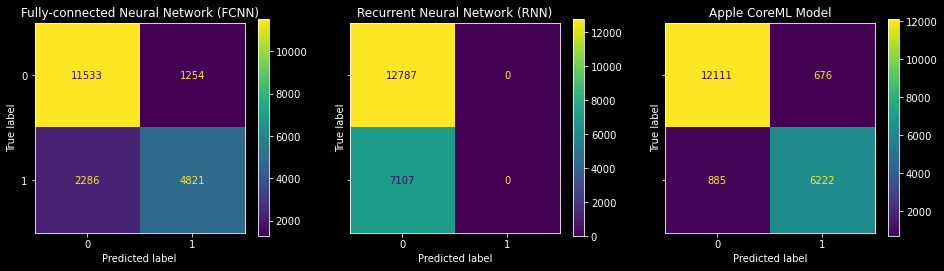

FCNN Stats: 82.21% accuracy, 39.53% loss
RNN Stats: 64.28% accuracy, nan% loss
Apple CoreML Stats: 92.15% accuracy, 7.85% loss


In [109]:
# To compare the networks, we will use a confusion matrix, which displays the distribution of correct and incorrect
# predictions. The format is as follows:
#
# [[ True Negatives     False Positives
#    False Negatives    True Positives ]]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import numpy as np

# Map the predictions of the FCNN and the RNN to be binary so as to match the true format.
force_validity = np.vectorize(lambda a: 1 if a > 0.5 else 0)
y_predict_fcnn = force_validity(y_predict_fcnn)
y_predict_rnn = force_validity(y_predict_rnn)

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 4)) # type: ignore

# Generate the confusion matrix for the FCNN predictions and display it.
cm_fcnn = confusion_matrix(y_true, y_predict_fcnn)
ConfusionMatrixDisplay(cm_fcnn).plot(ax=ax1)
ax1.set_title("Fully-connected Neural Network (FCNN)")

# Generate the confusion matrix for the RNN and display it.
cm_rnn = confusion_matrix(y_true, y_predict_rnn)
ConfusionMatrixDisplay(cm_rnn).plot(ax=ax2)
ax2.set_title("Recurrent Neural Network (RNN)")

# Generate the confusion matrix for the Apple CoreML model and display it.
cm_coreml = confusion_matrix(y_true, y_predict_coreml)
ConfusionMatrixDisplay(cm_coreml).plot(ax=ax3)
ax3.set_title("Apple CoreML Model")

plt.show()

print("FCNN Stats: %.2f%% accuracy, %.2f%% loss" % (evaluation_FCNN[1] * 100, evaluation_FCNN[0] * 100))
print("RNN Stats: %.2f%% accuracy, %.2f%% loss" % (evaluation_RNN[1] * 100, evaluation_RNN[0] * 100))
print("Apple CoreML Stats: %.2f%% accuracy, %.2f%% loss" % (evaluation_CORE_ML[1] * 100, evaluation_CORE_ML[0] * 100))
